### Import Libraries


In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

### Number of Components to keep


In [16]:
n_components = 30

In [17]:
channels = ["Red", "Green", "Blue"]

def plot_variance(variance):
    fig = plt.figure(figsize=(15, 4))
    for i, v in enumerate(variance):
        fig.add_subplot(1, 3, i+1)
        plt.title(f"{channels[i]} Channel")
        plt.ylabel('Variation explained')
        plt.xlabel('Eigen Value')
        plt.bar(list(range(1, n_components+1)), v, alpha=0.7,
                align='center', label='explained variance')
        plt.step(list(range(1, n_components+1)), np.cumsum(v),
                 where='mid', label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component')
        plt.legend(loc='best')

In [18]:

def plot_images(images):
    fig = plt.figure(figsize=(len(images)*4, 4))
    for i, image in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(image[0])
        plt.title(image[1])

### Loading the Image


In [19]:
image_rgb = np.array(Image.open('cube.jpg'))
image_rgb.shape

(953, 954, 3)

### Spliting Color Channels


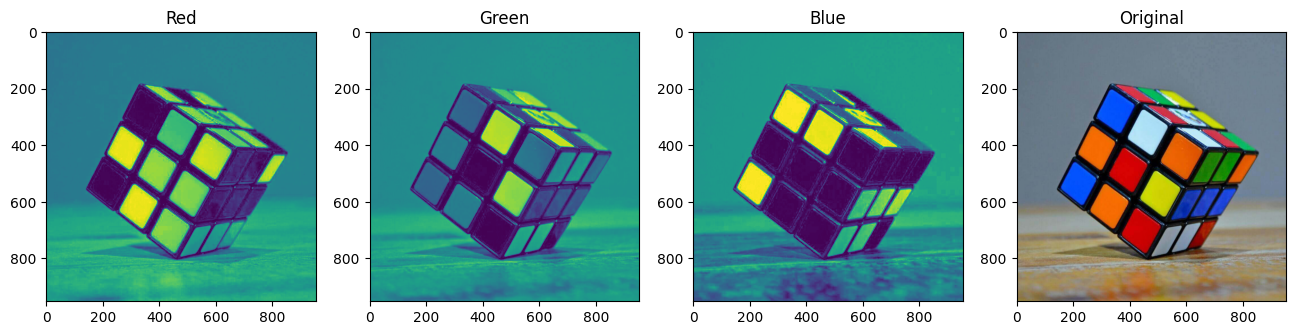

In [39]:
r_channel = image_rgb[:, :, 0]
g_channel = image_rgb[:, :, 1]
b_channel = image_rgb[:, :, 2]

plot_images([[r_channel, "Red"], [g_channel, "Green"],
            [b_channel, "Blue"], [image_rgb, 'Original']])

### Creatinng a Custom Class for PCA


In [22]:
class PCA_CUSTOM:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.n = None
        self.eigvecs = None
        self.eigvals = None

    def get_explained_variance_ratio(self):
        return self.eigvals[: self.n_components]/np.sum(self.eigvals)

    def fit_transform(self, image):

        self.mean = np.mean(image, axis=0)
        self.n = image.shape[1]
        centered = (image - self.mean) / self.n

        cov = np.dot(centered.T, centered)

        eigvals, eigvecs = np.linalg.eig(cov)

        idx = np.argsort(eigvals)[::-1]
        eigvecs = eigvecs[:, idx]
        self.eigvals = eigvals
        self.eigvecs = eigvecs[:, :self.n_components]

        reduced = np.dot(centered, self.eigvecs)
        return reduced

    def inverse_transform(self, reduced):
        reconstructed = np.dot(reduced, self.eigvecs.T) * self.n + self.mean
        reconstructed = np.clip(reconstructed, 0, 255)
        reconstructed = reconstructed.astype(np.uint8)
        return reconstructed

### Calculating Reduced Values


In [23]:
pca_r = PCA_CUSTOM(n_components=n_components)
reduced_r = pca_r.fit_transform(r_channel)

pca_g = PCA_CUSTOM(n_components=n_components)
reduced_g = pca_g.fit_transform(g_channel)

pca_b = PCA_CUSTOM(n_components=n_components)
reduced_b = pca_b.fit_transform(b_channel)

reduced_r.shape

(953, 30)

### Ploting Explained Variance Ratio For Custom Class (30 components)


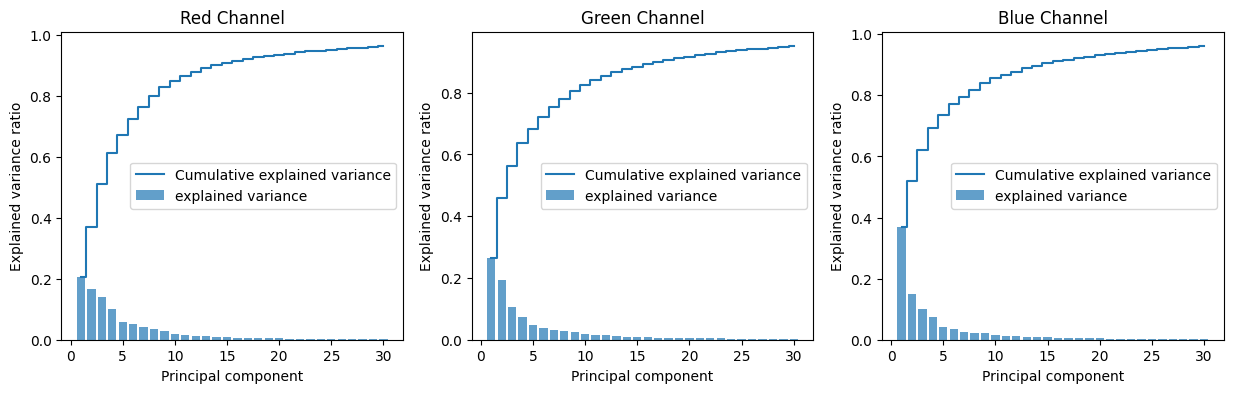

In [24]:
plot_variance([pca_r.get_explained_variance_ratio(), pca_g.get_explained_variance_ratio(), pca_b.get_explained_variance_ratio()])

### Reconstructing the Image from Reduced values


In [25]:
reconstructed_r = pca_r.inverse_transform(reduced_r)
reconstructed_g = pca_g.inverse_transform(reduced_g)
reconstructed_b = pca_b.inverse_transform(reduced_b)
reconstructed_custom = np.dstack(
    (reconstructed_r, reconstructed_g, reconstructed_b))

### Ploting the Reconstructed and Original Images


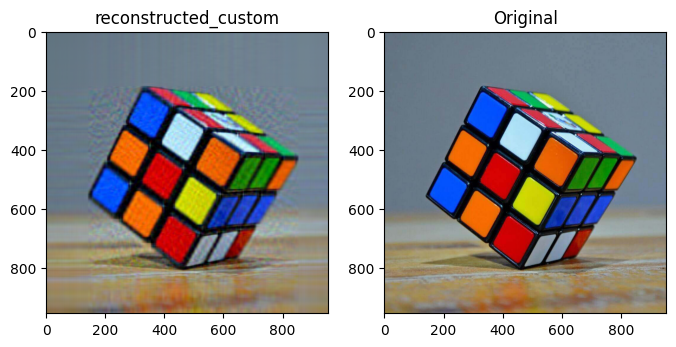

In [26]:
plot_images([[reconstructed_custom, 'reconstructed_custom'],
            [image_rgb, 'Original']])

## Redoing the same process with Scikit-learn For Comparison


### Normalizing the Image and spliting channels


In [27]:
r = r_channel / 0xff
g = g_channel / 0xff
b = b_channel / 0xff

### Calculating Reduced values using Scikit-learn


In [28]:
from sklearn.decomposition import PCA as sklearnPCA

pca_red = sklearnPCA(n_components=n_components)
reduced_red = pca_red.fit_transform(r)

pca_green = sklearnPCA(n_components=n_components)
reduced_green = pca_green.fit_transform(g)

pca_blue = sklearnPCA(n_components=n_components)
reduced_blue = pca_blue.fit_transform(b)

reduced_red.shape

(953, 30)

### Ploting Explained Variance Ratio For Scikit-learn Class


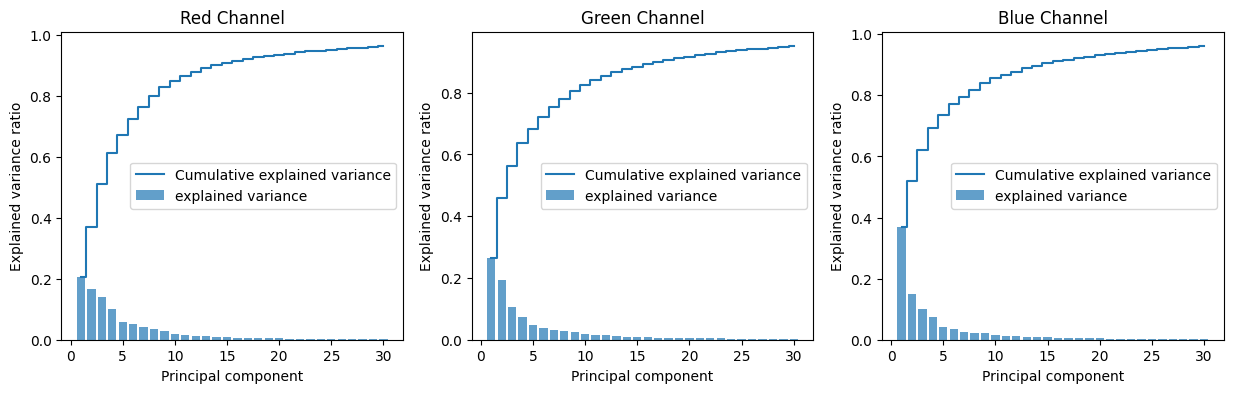

In [29]:
plot_variance([pca_red.explained_variance_ratio_, pca_green.explained_variance_ratio_, pca_blue.explained_variance_ratio_])

### Reconstructing the Image


In [30]:
reconstructed_red = pca_red.inverse_transform(reduced_red)
reconstructed_green = pca_green.inverse_transform(reduced_green)
reconstructed_blue = pca_blue.inverse_transform(reduced_blue)

reconstructed_scikit = np.dstack(
    (reconstructed_red, reconstructed_green, reconstructed_blue))

reconstructed_scikit = np.clip(reconstructed_scikit*255, 0, 255)

reconstructed_scikit = reconstructed_scikit.astype(np.uint8)

### Ploting Reconstructed and Original Image


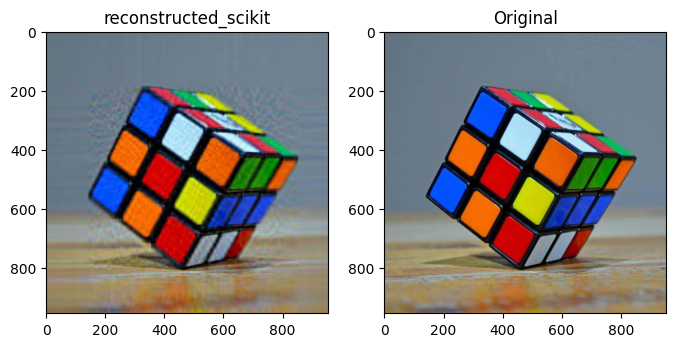

In [31]:
plot_images([[reconstructed_scikit, 'reconstructed_scikit'],
            [image_rgb, 'Original']])

### Ploting Both Reconstructed Images along side the Original


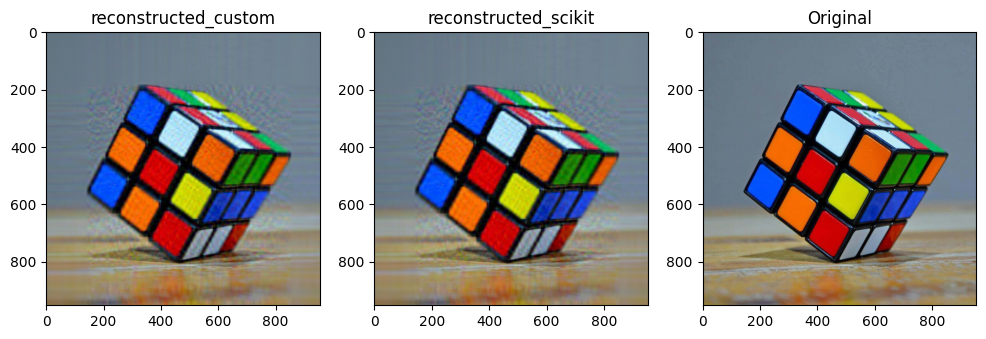

In [32]:
plot_images([[reconstructed_custom, 'reconstructed_custom'], [reconstructed_scikit, 'reconstructed_scikit'],
            [image_rgb, 'Original']])

### Calculate Mean Square Error for Reconstructed Images

to find out how much of data has been lost


In [33]:
def calculate_mse(original_image, reconstructed_image):
    squared_error = (original_image - reconstructed_image) ** 2
    mse = np.mean(squared_error)
    return mse

In [34]:
mse_custom = calculate_mse(image_rgb, reconstructed_custom)
mse_scikit = calculate_mse(image_rgb, reconstructed_scikit)
print("MSE of custom class: ", mse_custom)
print("MSE of scikit class: ", mse_scikit)

MSE of custom class:  36.02983736671792
MSE of scikit class:  36.028103168998854


### Testing Custom Class for Number of Components 1 to 300


In [35]:
# error_custom = []

# for n in range(300):
#     print(n+1, end='  \r')
#     pca_r = PCA_CUSTOM(n_components=n+1)
#     reduced_r = pca_r.fit_transform(r_channel)

#     pca_g = PCA_CUSTOM(n_components=n+1)
#     reduced_g = pca_g.fit_transform(g_channel)

#     pca_b = PCA_CUSTOM(n_components=n+1)
#     reduced_b = pca_b.fit_transform(b_channel)
#     reconstructed_r = pca_r.inverse_transform(reduced_r)
#     reconstructed_g = pca_g.inverse_transform(reduced_g)
#     reconstructed_b = pca_b.inverse_transform(reduced_b)
#     reconstructed_custom = np.dstack(
#         (reconstructed_r, reconstructed_g, reconstructed_b))
#     error_custom.append(calculate_mse(image_rgb, reconstructed_custom))

### Testing Scikit-learn Class for Number of Components 1 to 300


In [36]:
# error_scikit = []

# for n in range(300):
#     print(n+1, end='  \r')
#     pca_red = sklearnPCA(n_components=n+1)
#     reduced_red = pca_red.fit_transform(r)

#     pca_green = sklearnPCA(n_components=n+1)
#     reduced_green = pca_green.fit_transform(g)

#     pca_blue = sklearnPCA(n_components=n+1)
#     reduced_blue = pca_blue.fit_transform(b)

#     reconstructed_red = pca_red.inverse_transform(reduced_red)
#     reconstructed_green = pca_green.inverse_transform(reduced_green)
#     reconstructed_blue = pca_blue.inverse_transform(reduced_blue)

#     reconstructed_scikit = np.dstack(
#         (reconstructed_red, reconstructed_green, reconstructed_blue))

#     reconstructed_scikit = np.clip(reconstructed_scikit*255, 0, 255)

#     reconstructed_scikit = reconstructed_scikit.astype(np.uint8)
#     error_scikit.append(calculate_mse(image_rgb, reconstructed_scikit))

### Ploting the Mean Square Error for 1 to 200 Number of Components


In [37]:
with open('error_custom.npy', 'rb') as f:
    error_custom = np.load(f)

with open('error_scikit.npy', 'rb') as f:
    error_scikit = np.load(f)

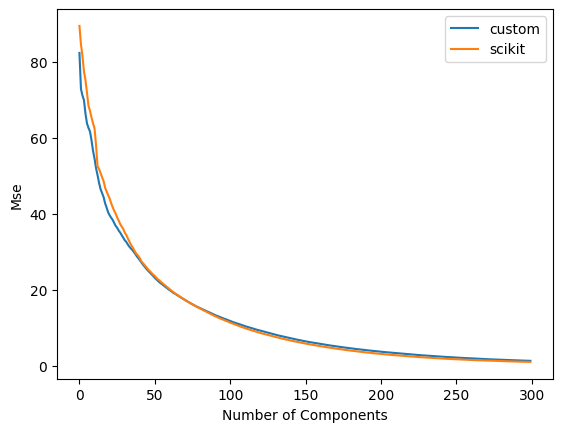

In [38]:
plt.plot(error_custom, label='custom')
plt.plot(error_scikit, label='scikit')
plt.xlabel('Number of Components')
plt.ylabel('Mse')
plt.legend()
plt.show()